In [1]:
%matplotlib inline
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np # linear algebra
import seaborn as sns
sns.set(style='whitegrid')
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os


In [93]:
df=pd.read_csv('SAheart.data', sep=",")
df

,row.names,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,2,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,3,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,4,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,5,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1
5,6,132,6.20,6.47,36.21,Present,62,30.77,14.14,45,0
6,7,142,4.05,3.38,16.20,Absent,59,20.81,2.62,38,0
7,8,114,4.08,4.59,14.60,Present,62,23.11,6.72,58,1
8,9,114,0.00,3.83,19.40,Present,49,24.86,2.49,29,0
9,10,132,0.00,5.80,30.96,Present,69,30.11,0.00,53,1


In [3]:
X = df[['age','ldl']].values
y = df.chd.values

In [43]:
# Define the max-min normalized function
def min_max_normalized(data):
    col_max = np.max(data, axis=0)
    col_min = np.min(data, axis=0)
    return np.divide(data - col_min, col_max - col_min)

# Define the mean-std normalized function
def mean_std_normalized(data):
    col_mean = np.mean(data, axis=0)
    col_std = np.std(data, axis=0)
    return np.divide(data - col_mean, col_std)

# Definition of the weights of evidence w_j = beta_j*phi(x)+alpha_j, refer to Equ.16 in paper NNBelief
def trained_weight(A,b,X):  
    weights= np.empty((len(X.index), len(A)))
    for i in range(len(A)):
        weights[:,[i]]= np.array([X[i]*A[i]+b]).T
    return weights 

# Calculate positive & negative weights of evidence (w^+,w^-，参见Equ.16下面那段描述)
def weight_of_evidence(weight):
    W=[]
    if isinstance(weight[0],list):
        for i in range(len(weight)):
            W.append((max(0,weight[i][0]),max(0,-weight[i][0])))
    else:
        for i in range(len(weight)):
            W.append((max(0,weight[i]),max(0,-weight[i])))        
    return W

# Calculate the sum of positive & negative weights (参见Equ.17下面一行公式)
def sum_weight(W):
    weight_pos_temp = np.empty((W.shape[0], W.shape[1]))
    weight_neg_temp = np.empty((W.shape[0], W.shape[1]))
    weight_pos = np.empty((W.shape[0], 1))
    weight_neg = np.empty((W.shape[0], 1))
    for i in range(W.shape[1]):
        weight_pos_temp[:,[i]]=np.array(weight_of_evidence(W[:,[i]]))[:,[0]]
        weight_neg_temp[:,[i]]=np.array(weight_of_evidence(W[:,[i]]))[:,[1]]
    weight_pos=np.sum(weight_pos_temp,axis=1)
    weight_neg=np.sum(weight_neg_temp,axis=1)
    return(weight_pos,weight_neg)

# Definition of the degree of conflict k=[1-exp(-w^+)]*[1-exp(-w^-)] (Equ.21c)
def degree_of_conflict(W_pos,W_neg):
    k=(1-np.exp(-1*W_pos))*(1-np.exp(-1*W_neg))
    return k

# Calculate conflict from trained parameters and feature values
def conflict(A,b,X):
    w_j=trained_weight(A,b,X)   
    weight_pos,weight_neg=sum_weight(w_j)
    k=degree_of_conflict(weight_pos,weight_neg)
    return k

def centralized(data):
    col_mean = np.mean(data, axis=0)
    return (data - col_mean)


In [58]:

ldl = np.arange(0,15,0.3)
age = np.arange(0,70,1.4)

# ldl_norm=mean_std_normalized(ldl)
# age_norm=mean_std_normalized(age)


ldl_norm=centralized(ldl)
age_norm=centralized(age)


#将原始数据变成网格数据形式
X,Y = np.meshgrid(age_norm,ldl_norm)

In [6]:
beta= [[0.5974239], [0.3825687]]

In [7]:
alpha= [-0.36972204]

Text(0.5,1,u'degree of conflict')

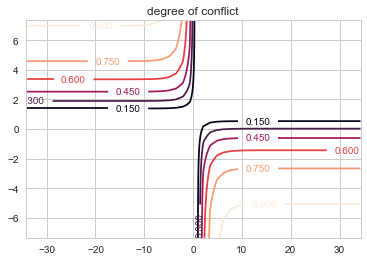

In [59]:
kk=conflict(beta,alpha,pd.DataFrame({0:(X.flatten()),1:(Y.flatten())})).reshape(50,50)
fig, ax = plt.subplots()
CS = ax.contour(X, Y, kk)
# plt.ylim(ymin=-1, ymax=1)
# plt.xlim(xmin=-1, xmax=1)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('degree of conflict')

In [50]:
ldl_norm

array([-7.425, -7.275, -7.125, -6.975, -6.825, -6.675, -6.525, -6.375,
       -6.225, -6.075, -5.925, -5.775, -5.625, -5.475, -5.325, -5.175,
       -5.025, -4.875, -4.725, -4.575, -4.425, -4.275, -4.125, -3.975,
       -3.825, -3.675, -3.525, -3.375, -3.225, -3.075, -2.925, -2.775,
       -2.625, -2.475, -2.325, -2.175, -2.025, -1.875, -1.725, -1.575,
       -1.425, -1.275, -1.125, -0.975, -0.825, -0.675, -0.525, -0.375,
       -0.225, -0.075,  0.075,  0.225,  0.375,  0.525,  0.675,  0.825,
        0.975,  1.125,  1.275,  1.425,  1.575,  1.725,  1.875,  2.025,
        2.175,  2.325,  2.475,  2.625,  2.775,  2.925,  3.075,  3.225,
        3.375,  3.525,  3.675,  3.825,  3.975,  4.125,  4.275,  4.425,
        4.575,  4.725,  4.875,  5.025,  5.175,  5.325,  5.475,  5.625,
        5.775,  5.925,  6.075,  6.225,  6.375,  6.525,  6.675,  6.825,
        6.975,  7.125,  7.275,  7.425])

In [51]:
np.mean(ldl, axis=0)

7.4249999999999998

In [52]:
np.mean(age, axis=0)

34.649999999999999

In [49]:
_max = float('-inf')
for k in kk:
    _max = max(_max, max(k))
print(_max)

0.959655274127


Text(0.5,1,u'degree of conflict')

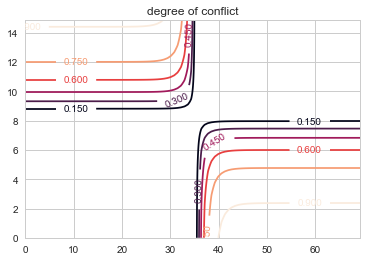

In [57]:
kk=conflict(beta,alpha,pd.DataFrame({0:(X.flatten()),1:(Y.flatten())})).reshape(100,100)
fig, ax = plt.subplots()
CS = ax.contour(age, ldl, kk)
# plt.ylim(ymin=-1, ymax=1)
# plt.xlim(xmin=-1, xmax=1)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('degree of conflict')

NameError: name 'df_norm' is not defined

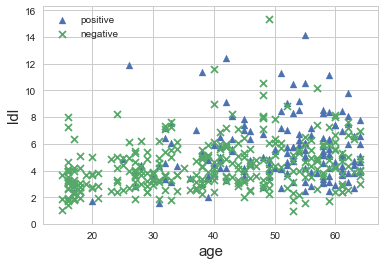

In [61]:
fig, ax = plt.subplots()
ax.scatter(df[df["chd"]==1]["age"],df[df["chd"]==1]["ldl"],marker='^',label='positive')
ax.scatter(df[df["chd"]==0]["age"],df[df["chd"]==0]["ldl"],marker='x',label='negative')
ax.set_xlabel('age', fontsize=15)
ax.set_ylabel('ldl', fontsize=15)
ax.legend()

In [72]:
seed = 9
np.random.seed(seed)

In [85]:
train_index = [ 7, 31, 45, 30, 14,  3,  1, 34,  2, 16, 21, 37, 12, 10,  0, 47,  9,
       42,  4, 25, 23, 49, 26, 19, 46, 17, 36, 40, 38, 43, 39, 13, 44, 32,
        8, 20, 35,  6, 15, 28]

X = df[['age','ldl']].values
y = df.chd.values

In [86]:
train_X = X[train_index]
train_y = y[train_index]
test_X = X[test_index]
test_y = y[test_index]


train_X = mean_std_normalized(train_X)
test_X = mean_std_normalized(test_X)


In [87]:


#verify the normalization results by plotting
df_trainX = pd.DataFrame(train_X)
df_testX = pd.DataFrame(test_X)
df_train_index = pd.DataFrame(train_index)
df_test_index = pd.DataFrame(test_index)

df_X=pd.concat([df_trainX,df_testX],ignore_index=True)
df_y=pd.concat([pd.DataFrame(train_y),pd.DataFrame(test_y)],ignore_index=True)
df_norm=pd.concat([df_X,df_y],axis=1)
df_norm.columns=[0,1,'chd']

df_norm.head()

,0,1,chd
0,1.034382,-0.161992,1
1,0.163324,0.443846,1
2,0.308500,-0.607665,0
3,0.090735,-0.384829,1
4,0.671441,-0.962811,0


In [99]:
beta[0]=0.49555755
beta[1]=0.49758905
alpha= -0.3306306

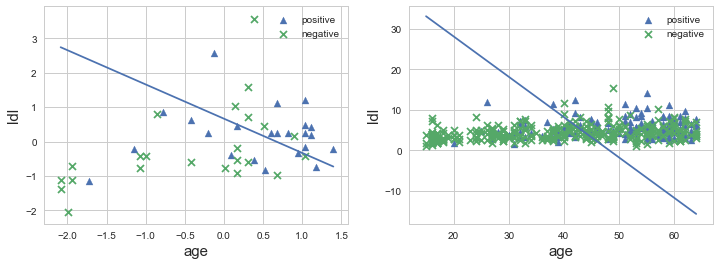

In [100]:
def x2(x1):    #x2=-(b1/b2)*x1-a/b2=(-b1*x1-a)/b2
    return (-beta[0] * x1 - alpha) / beta[1]
def x3(x1):
    return (-beta[0] * x1)/ beta[1]+(-alpha+df["age"].mean()*beta[0])/beta[1]+df["ldl"].mean()
xlim_norm1=df_norm.iloc[:,[0]].min()
xlim_norm2=df_norm.iloc[:,[0]].max()
ylim_norm1=df_norm.iloc[:,[1]].min()
ylim_norm2=df_norm.iloc[:,[1]].max()
xlim1=df["age"].min()
xlim2=df["age"].max()
ylim1=df["ldl"].min()
ylim2=df["ldl"].max()

x1_plot = np.linspace(xlim_norm1, xlim_norm2, 1000)
x11_plot = np.linspace(xlim1, xlim2, 1000)
x2_plot = x2(x1_plot)
x3_plot = x3(x11_plot)

fig, ax = plt.subplots(1,2, figsize=(12,4))
# ax.scatter(df[df["chd"]==1]["age"],df[df["chd"]==1]["ldl"],marker='^',label='positive')
# ax.scatter(df[df["chd"]==0]["age"],df[df["chd"]==0]["ldl"],marker='x',label='negative')
ax[0].scatter(df_norm[df_norm["chd"]==1][0],df_norm[df_norm["chd"]==1][1],marker='^',label='positive')
ax[0].scatter(df_norm[df_norm["chd"]==0][0],df_norm[df_norm["chd"]==0][1],marker='x',label='negative')
ax[0].plot(x1_plot, x2_plot)
ax[0].set_xlabel('age', fontsize=15)
ax[0].set_ylabel('ldl', fontsize=15)
plt.xlim=(xlim_norm1,xlim_norm2)
plt.ylim=(ylim_norm1,ylim_norm2)
ax[0].legend()

ax[1].scatter(df[df["chd"]==1]["age"],df[df["chd"]==1]["ldl"],marker='^',label='positive')
ax[1].scatter(df[df["chd"]==0]["age"],df[df["chd"]==0]["ldl"],marker='x',label='negative')
ax[1].plot(x11_plot, x3_plot)
ax[1].set_xlabel('age', fontsize=15)
ax[1].set_ylabel('ldl', fontsize=15)
plt.xlim=(xlim1,xlim2)
plt.ylim=(ylim1,ylim2)
ax[1].legend()